### This note book is modified based on Anthony Sarkis's Github repo
https://github.com/swirlingsand/deeper-traffic-lights/blob/master/object_detection_sim_run.ipynb

# Imports

In [9]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import time

In [2]:
print(tf.__version__)

1.3.0


## Env setup

In [3]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [4]:
os.chdir('/Users/kyleguan/anaconda/lib/python2.7/site-packages/tensorflow/Models')
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Frozen model download
The model 'resnet-udacity-sim-large-10-regions/frozen_inference_graph.pb' can be downloaded from
https://drive.google.com/drive/u/0/folders/0BzcEGp8MN5DieURQZGFZclZWRFU


In [5]:
MODEL_NAME = 'resnet-udacity-sim-large-10-regions'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_CKPT = os.path.join('/Users/kyleguan/Documents/CarND_term3/traffic_light_detection',PATH_TO_CKPT)
NUM_CLASSES = 14
print(PATH_TO_CKPT)

/Users/kyleguan/Documents/CarND_term3/traffic_light_detection/resnet-udacity-sim-large-10-regions/frozen_inference_graph.pb


## Load a (frozen) Tensorflow model into memory.

In [10]:
load_start = time.time()
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
load_end = time.time()
print("Time to load the model (msec): ", (load_end - load_start)*1000)

Time to load the model (msec):  5799.107074737549


### Category indices


In [11]:
category_index={1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'GreenLeft'},
                4: {'id': 4, 'name': 'GreenRight'}, 5: {'id': 5, 'name': 'RedLeft'}, 6: {'id': 6, 'name': 'RedRight'}, 
                7: {'id': 7, 'name': 'Yellow'}, 8: {'id': 8, 'name': 'off'}, 9: {'id': 9, 'name': 'RedStraight'}, 
                10: {'id': 10, 'name': 'GreenStraight'}, 11: {'id': 11, 'name': 'GreenStraightLeft'}, 
                12: {'id': 12, 'name': 'GreenStraightRight'}, 13: {'id': 13, 'name': 'RedStraightLeft'}, 
                14: {'id': 14, 'name': 'RedStraightRight'}}

## Helper code

In [16]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [12]:
from glob import glob
PATH_TO_TEST_IMAGES_DIR = '/Users/kyleguan/Documents/CarND_term3/traffic_light_detection/traffic_light_images'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'traffic_light_1.jpg')]
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
IMAGE_SIZE = (9, 6)

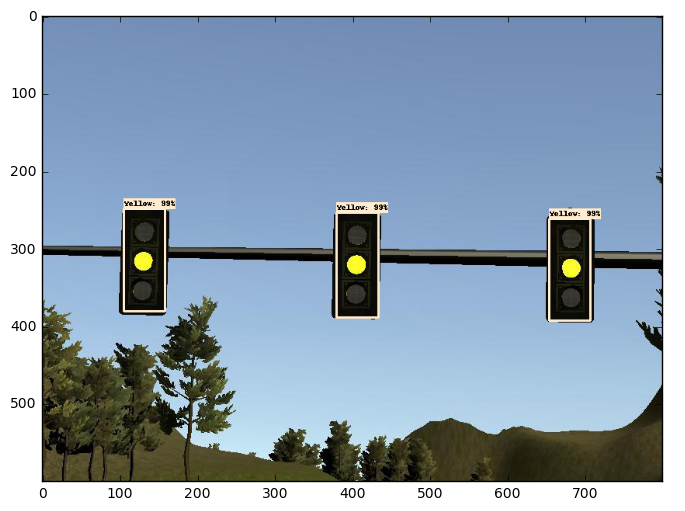

Process time in seconds:  7.395004034042358
Color: Yellow , Confidence:  0.993499


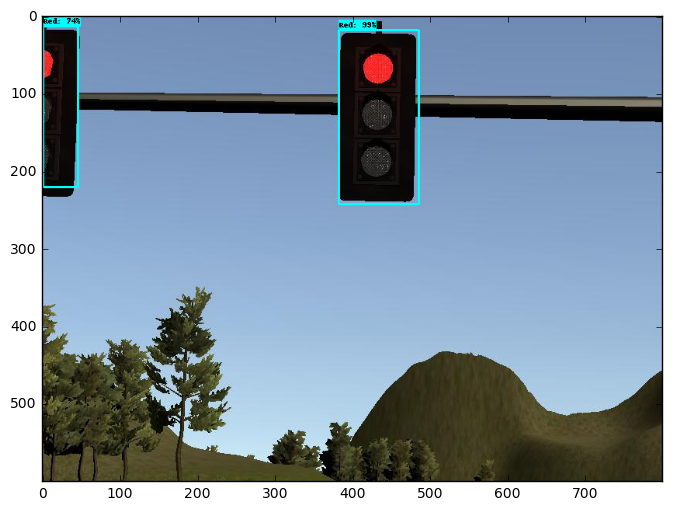

Process time in seconds:  3.4090521335601807
Color: Red , Confidence:  0.992589


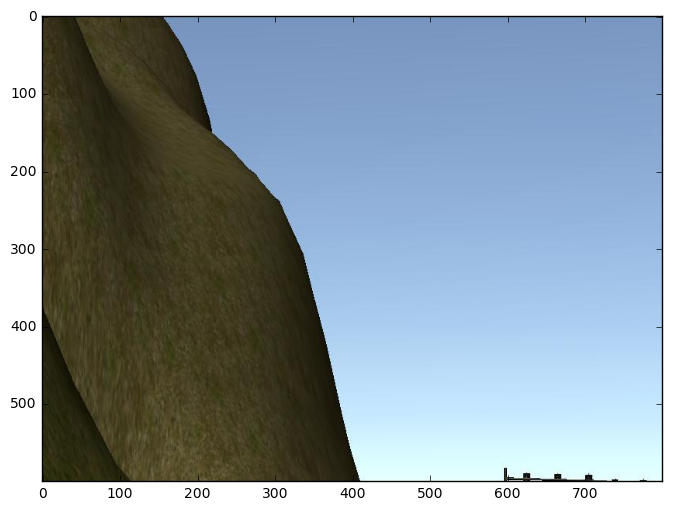

Process time in seconds:  3.394308090209961
No traffic light detected!


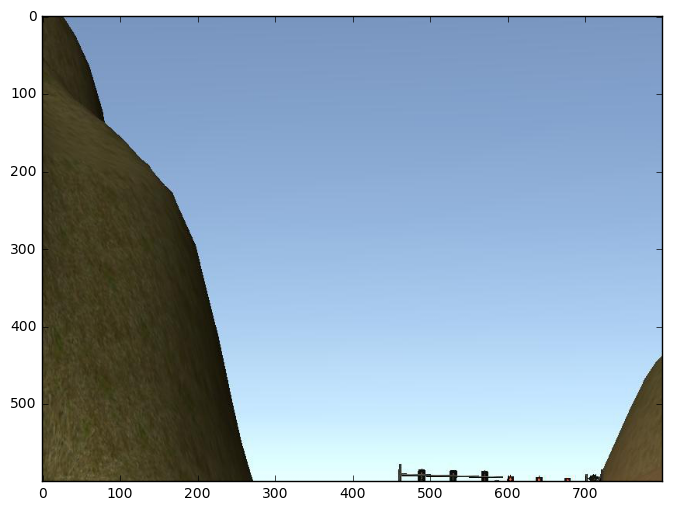

Process time in seconds:  3.435528039932251
No traffic light detected!


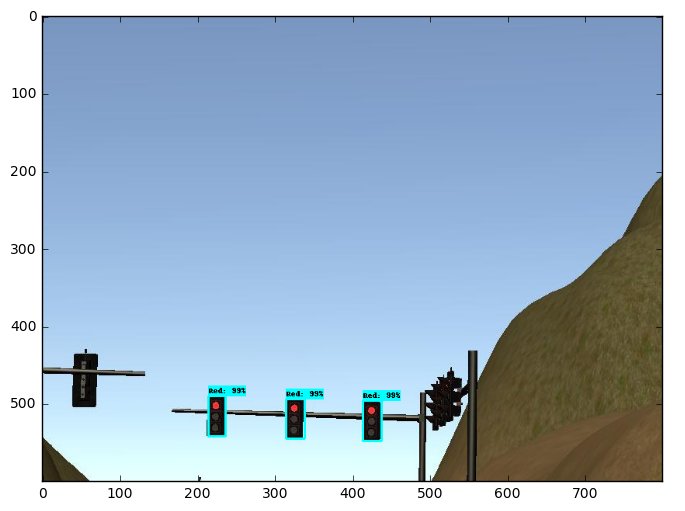

Process time in seconds:  3.448652982711792
Color: Red , Confidence:  0.996273


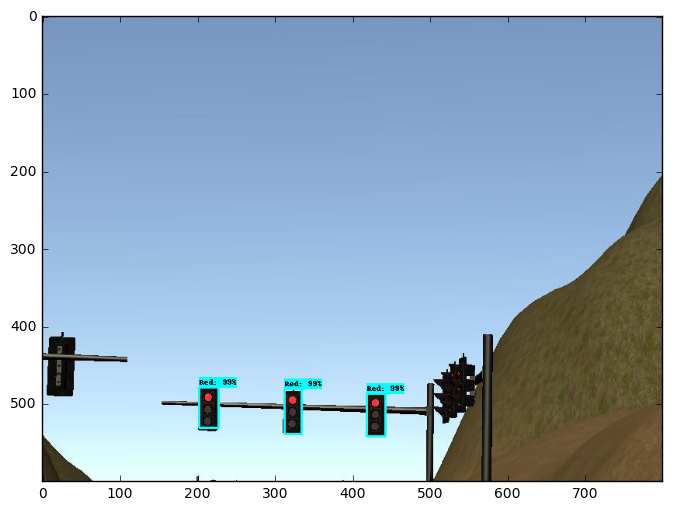

Process time in seconds:  3.7283380031585693
Color: Red , Confidence:  0.994623


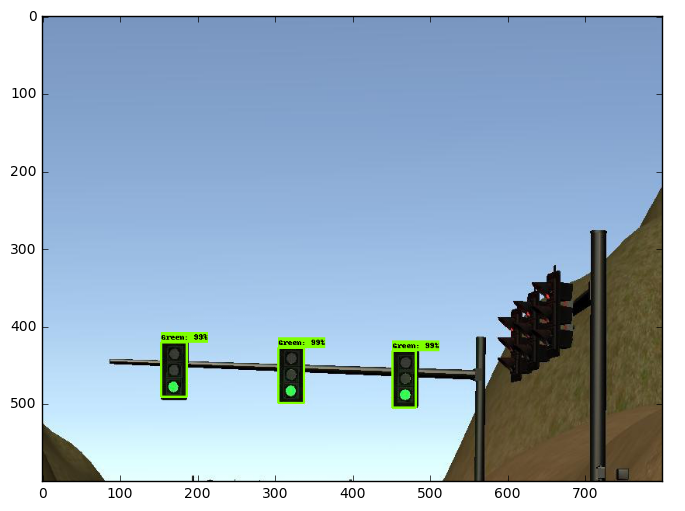

Process time in seconds:  3.4346160888671875
Color: Green , Confidence:  0.995483


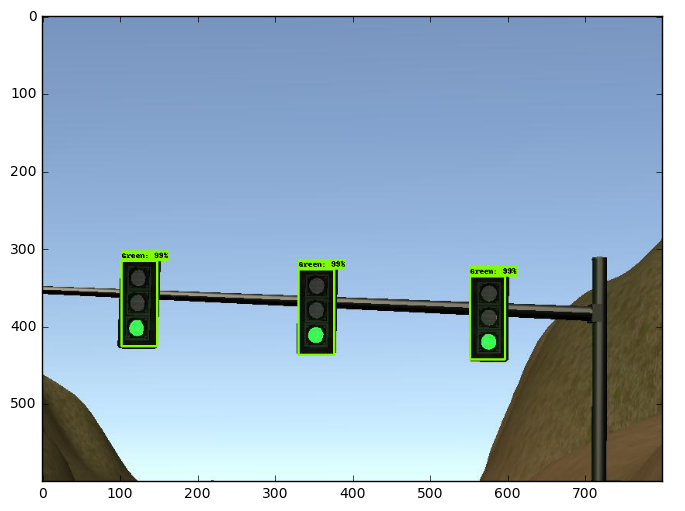

Process time in seconds:  3.4187750816345215
Color: Green , Confidence:  0.997653


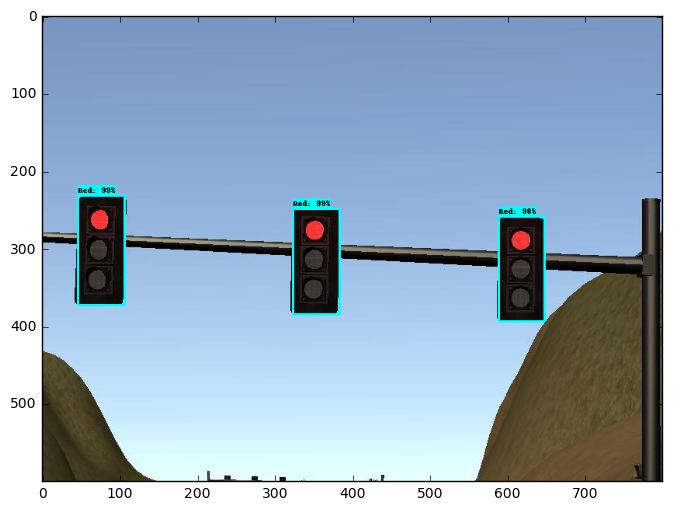

Process time in seconds:  3.38155198097229
Color: Red , Confidence:  0.994337


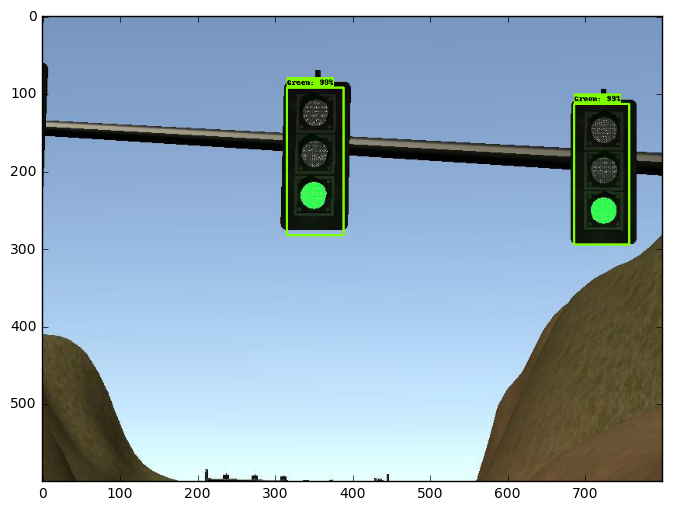

Process time in seconds:  3.3837718963623047
Color: Green , Confidence:  0.993523


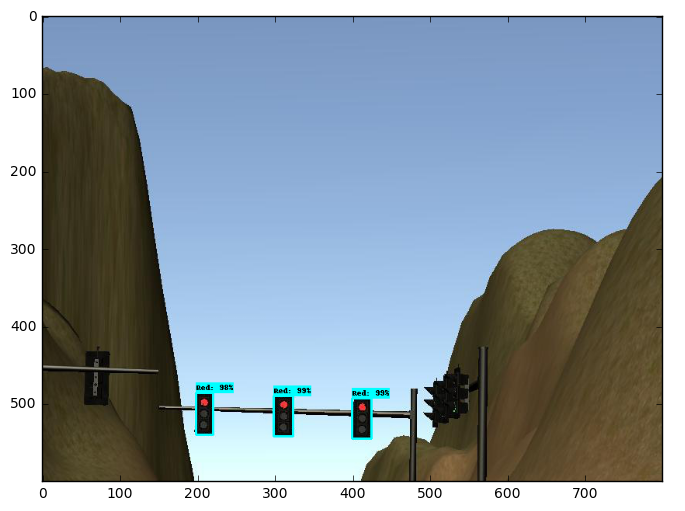

Process time in seconds:  3.429565906524658
Color: Red , Confidence:  0.993571


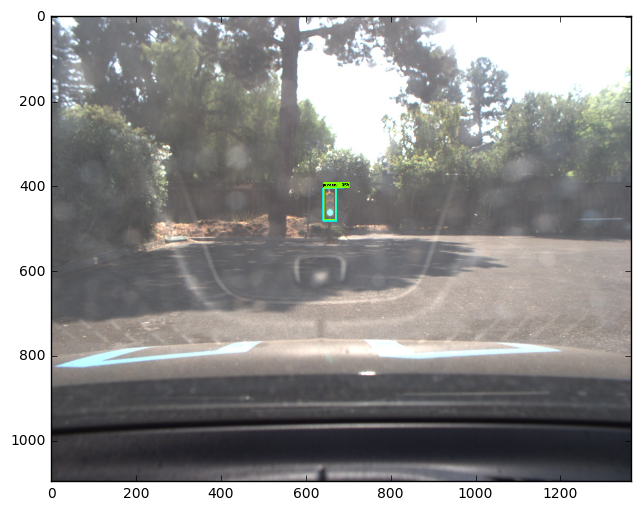

Process time in seconds:  3.2699859142303467
Color: Red , Confidence:  0.378074


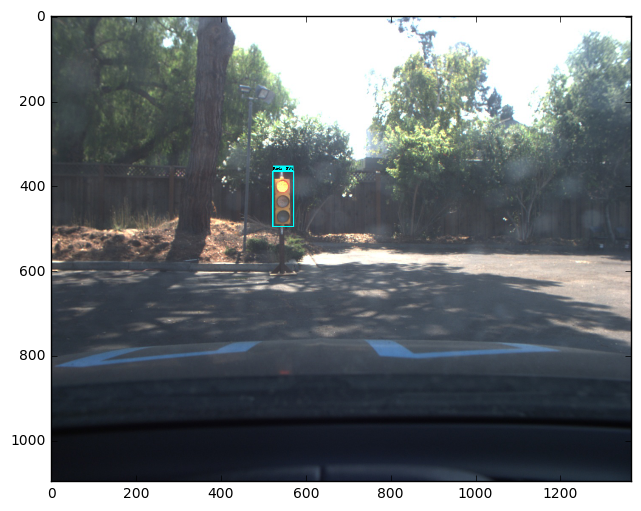

Process time in seconds:  3.1937108039855957
Color: Red , Confidence:  0.995655


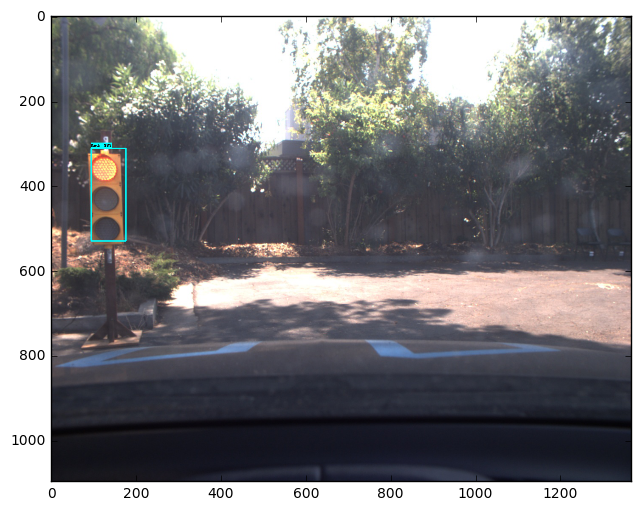

Process time in seconds:  3.1885430812835693
Color: Red , Confidence:  0.98928


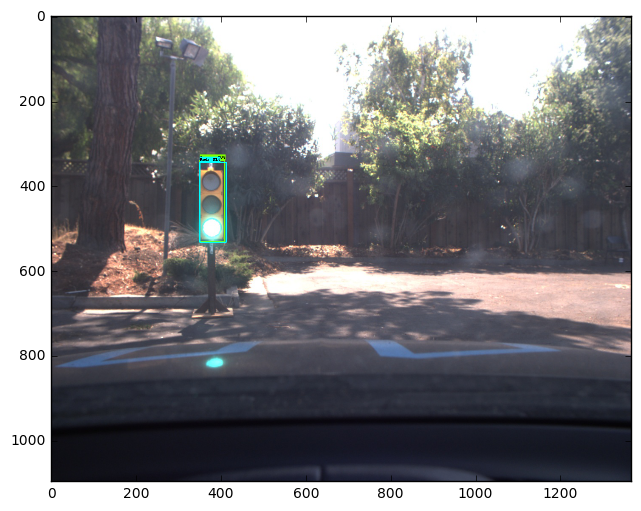

Process time in seconds:  3.2019221782684326
Color: Green , Confidence:  0.807517


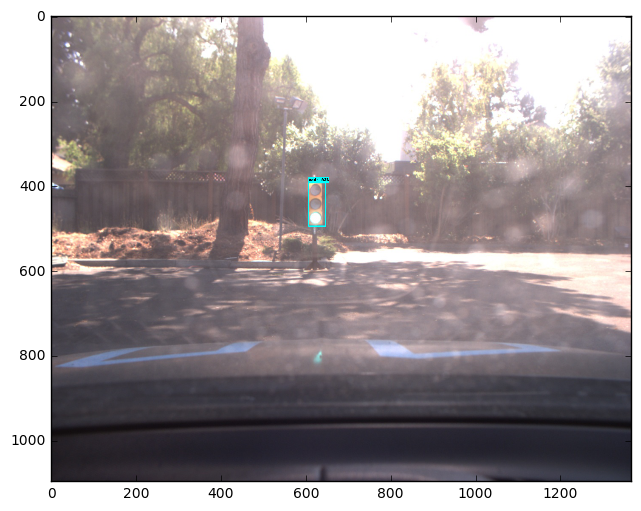

Process time in seconds:  3.1968469619750977
Color: Red , Confidence:  0.927312


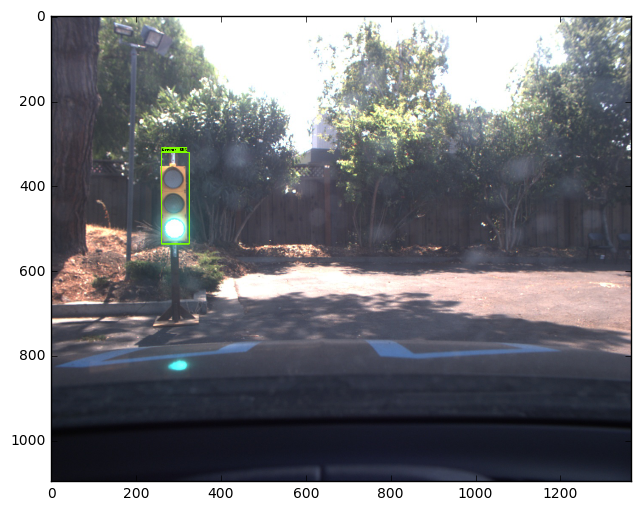

Process time in seconds:  3.149955987930298
Color: Green , Confidence:  0.851219


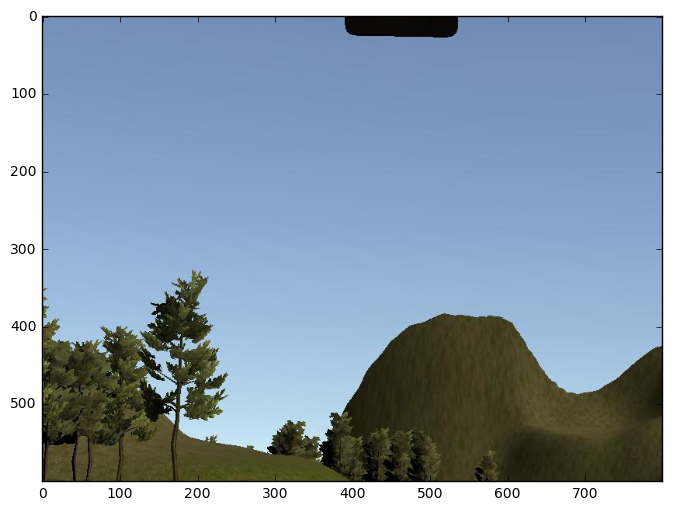

Process time in seconds:  3.3252780437469482
No traffic light detected!


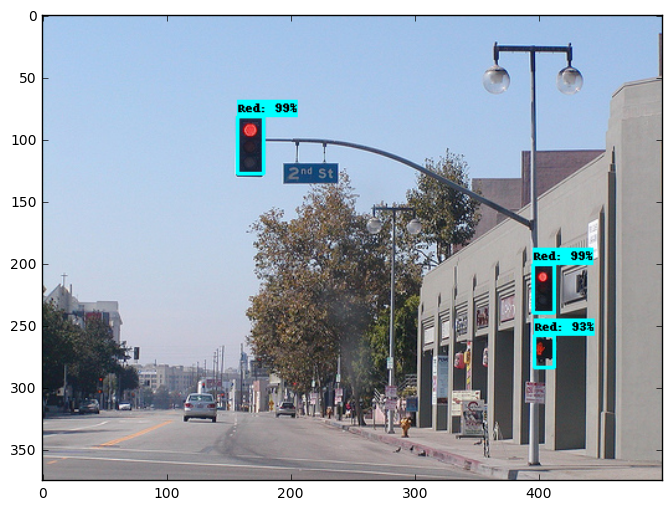

Process time in seconds:  3.342787981033325
Color: Red , Confidence:  0.997077


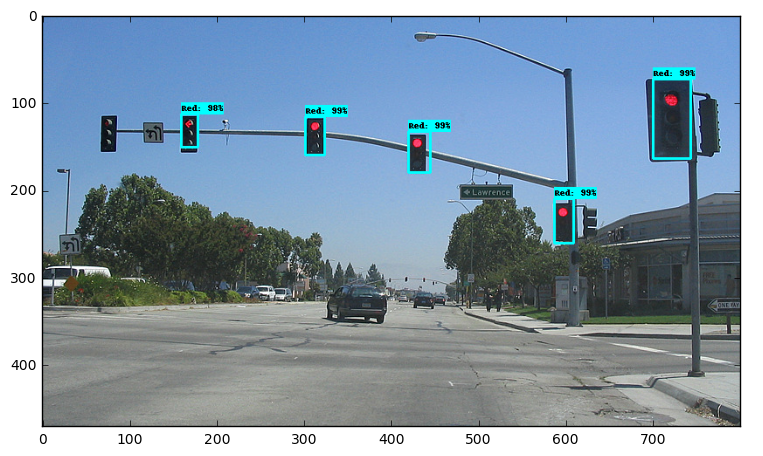

Process time in seconds:  2.7075958251953125
Color: Red , Confidence:  0.995803


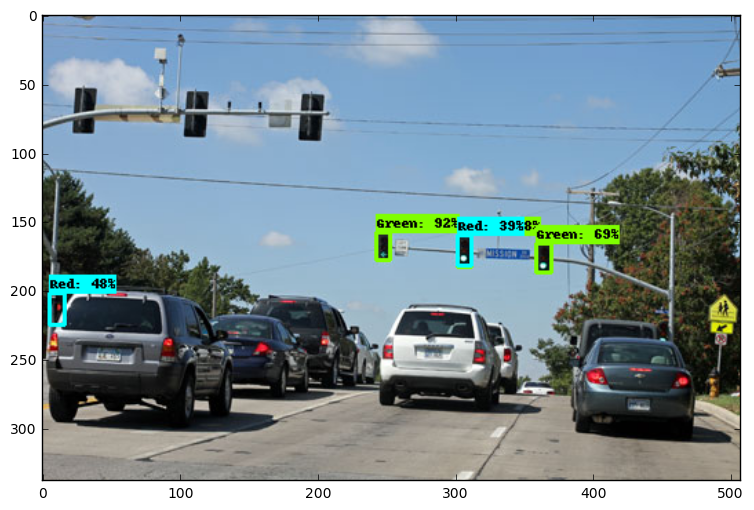

Process time in seconds:  3.2063770294189453
Color: Green , Confidence:  0.920369


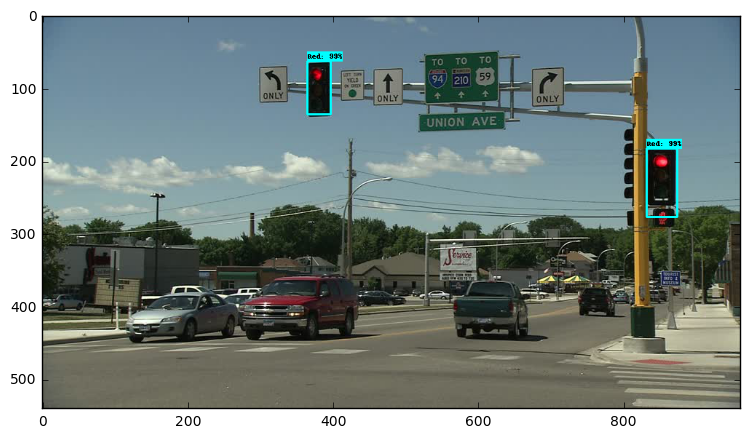

Process time in seconds:  2.6389660835266113
Color: Red , Confidence:  0.995245


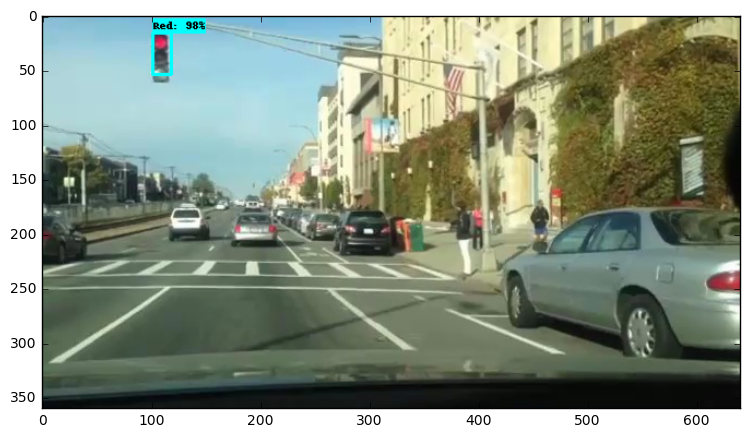

Process time in seconds:  2.8038740158081055
Color: Red , Confidence:  0.983277


In [17]:
import time
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      time_start=time.time()   
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,min_score_thresh=.2,
          line_thickness=3)
      time_end = time.time()    
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      plt.show()
      print("Process time in seconds: ", (time_end - time_start))  
      classes=np.squeeze(classes)
      scores=np.squeeze(scores)
      if scores[0]>0.2:
           print('Color:', category_index[classes[0]]['name'],', Confidence: ',scores[0] )
      else:
           print("No traffic light detected!")